In [1]:
import pandas as pd
import numpy as np
import yaml
import networkx as nx
import matplotlib.pyplot as plt

from pathlib import Path
from dag_gettsim.aux_funcs import elementwise_min

In [2]:
from dag_gettsim.dag import compute_taxes_and_transfers

In [3]:
from gettsim.pre_processing.policy_for_date import get_policies_for_date

In [4]:
df = pd.read_csv("gettsim/tests/test_dfs_ssc.csv")
params = yaml.safe_load(
    Path("gettsim", "soz_vers_beitr.yaml").read_text(encoding="utf-8")
)

In [5]:
year_df = df.query("jahr == 2002")

In [6]:
year_params = get_policies_for_date(year=2002, group="soz_vers_beitr", raw_group_data=params)

In [9]:
data, dag = compute_taxes_and_transfers(
    dict(year_df), params=year_params, targets=["ges_krankv_beit_m"], return_dag=True)

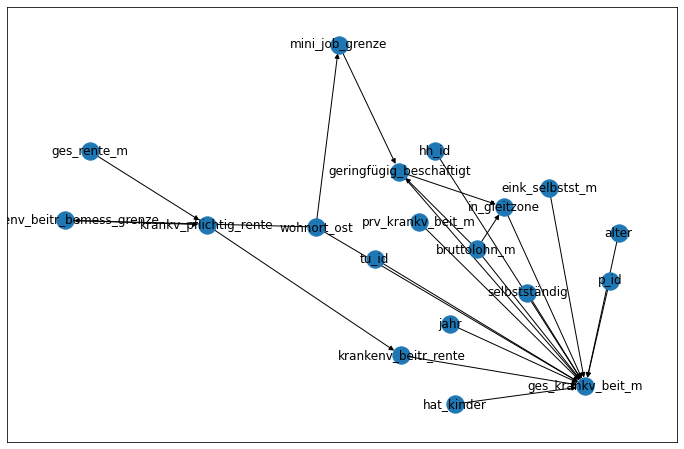

In [10]:
fig, ax = plt.subplots(figsize=(12, 8))

nx.draw_networkx(dag, ax=ax)
